In [4]:
from PIL import Image
import numpy as np
import pandas as pd
import os, os.path
from scipy import misc
import glob
import sys
from matplotlib.pyplot import imshow
import imageio
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
import random
np.seterr(all='raise');
import warnings
warnings.filterwarnings('ignore')

initial image


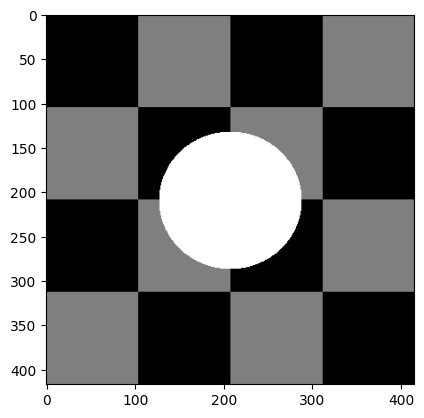

In [14]:
path = './test1.bmp'
arr = imageio.imread(path)
labels = np.array(arr / 127, dtype=int)
print ("initial image")
imshow(arr, cmap='gray');

In [6]:
arr.shape

(1920, 1920, 3)

In [7]:
tmp = plt.gcf().clear()

<Figure size 640x480 with 0 Axes>

In [8]:
def add_noise (arr, var):
    noise = np.random.normal(0, np.sqrt(var), arr.shape)
    noisy_arr = arr + noise
    return noisy_arr

In [9]:
def naive_bayes_learning(arr, noisy_arr, labels):
    class_info = []
    number_of_pixels = arr.size
    for cls in [0,1,2]:
        tmp = []
        for i in range(0, len(arr)):
            for j in range(0, len(arr[0])):
                if (labels[i][j]==cls).any():
                    tmp.append(noisy_arr[i][j])
        tmp = np.asarray(tmp)
        class_mean = np.mean(tmp)
        class_var = np.var(tmp)
        class_freq = len(tmp)
        class_probabilty = class_freq/number_of_pixels
        class_info.append([class_probabilty, class_mean, class_var])
    return class_info

In [10]:
def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

In [11]:
def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty).any():
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noisy Image with var 100


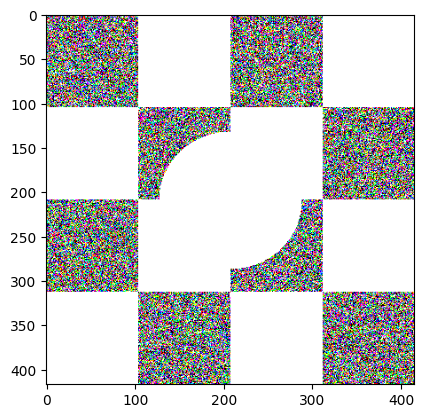

Naive Bayes Classifier Labels


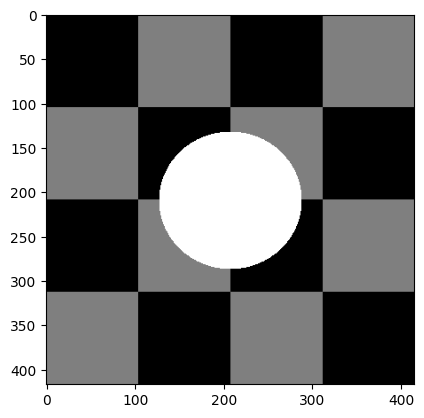

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noisy Image with var 1000


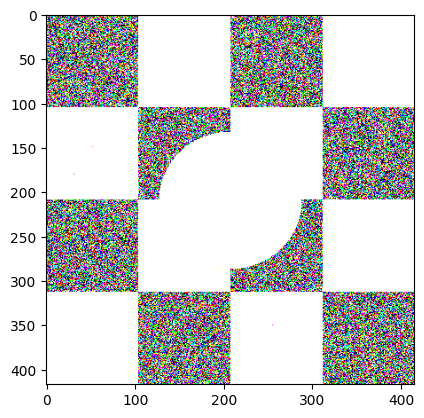

Naive Bayes Classifier Labels


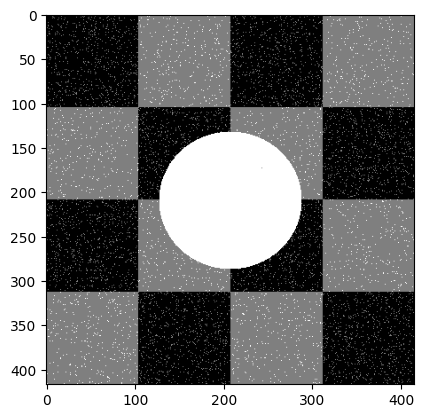

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noisy Image with var 20000


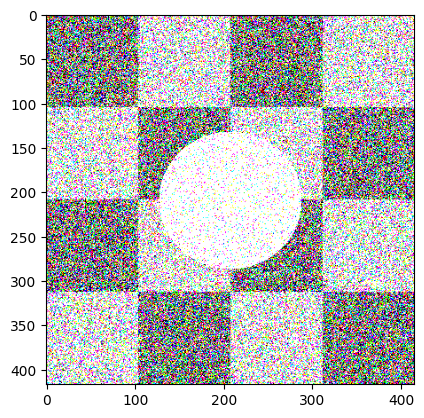

Naive Bayes Classifier Labels


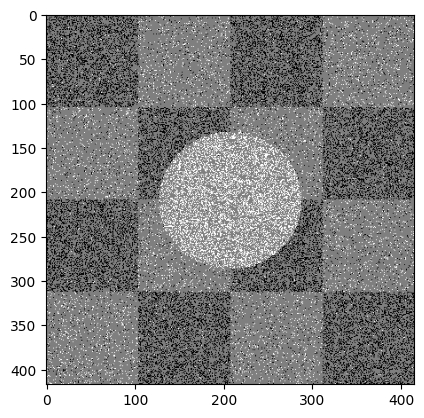

In [15]:
variance_list = [100, 1000, 20000]
for var in variance_list:
    noisy_arr = add_noise(arr, var)
    cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    prediciton_array = naive_bayes_predict(noisy_arr, cls_info)
    print ("Noisy Image with var", var)
    plt.imshow(noisy_arr, cmap='gray')
    plt.show()
    print ("Naive Bayes Classifier Labels")
    plt.imshow(prediciton_array, cmap='gray')
    plt.show()

In [16]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

In [17]:
def differnce(a,b):
    if (a==b):
        return -1
    else:
        return 1

In [18]:
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * differnce(w[i][j], w[a][b])
    return energy

In [19]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant
def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))
def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

In [20]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * differnce(w[i][j], w[a][b]) 
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * differnce(new_value, w[a][b])
    return new_energy - initial_energy

In [21]:
def simulated_annealing(init_w, class_labels, temprature_function,
                        pixels, betha, cls_info, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)

        r = random.uniform(0, 1)

        if (delta<=0).any():
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0
                
            if r < k:
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [22]:
def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

In [30]:
def a_complete_set_for_part_1 (arr, max_iter=1000000,var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    noisy_arr = add_noise(arr, var)
    ax1.imshow(noisy_arr, cmap='gray')
    rows = len(noisy_arr)
    cols = len(noisy_arr[0])
    cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    initial_arr = naive_bayes_predict(noisy_arr, cls_info)
    ax2.imshow(initial_arr, cmap='gray')
    convert_to_class_labels(initial_arr)
    w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                        noisy_arr, betha, cls_info, neighbor_indices, max_iteration=max_iter)
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')
    ax4.imshow(test_array, cmap='gray')
    plt.show()

In [31]:
plt.figure(figsize=(15, 20), dpi=100, facecolor='w', edgecolor='k')

<Figure size 1500x2000 with 0 Axes>

<Figure size 1500x2000 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


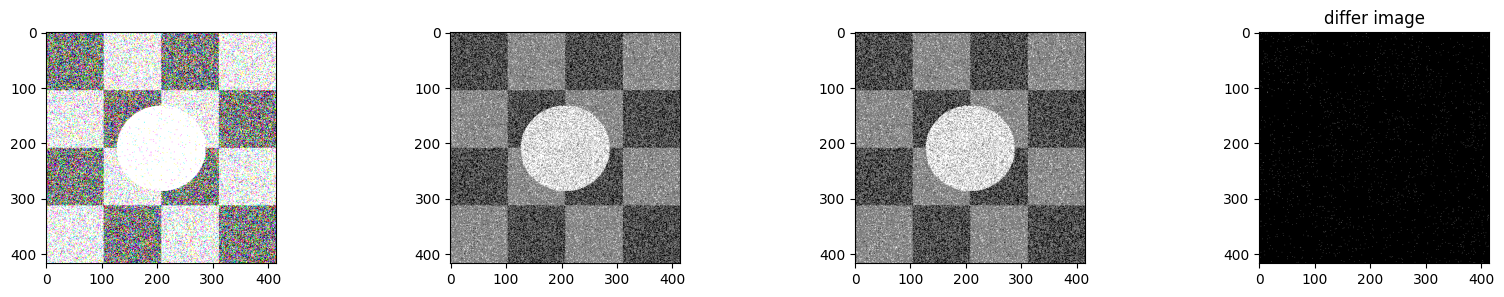

In [32]:
a_complete_set_for_part_1(arr, max_iter=1e4, var=1e4, betha=1e2)

In [ ]:
def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==(arr[i][j]/127).astype(int)).any():
                correct+=1
    return correct/(len(arr[0])*len(arr))